https://github.com/wallinm1/kaggle-facebook-bot/blob/master/facebook_notebook.ipynb

In [1]:
import itertools
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
train = pd.read_csv('../input/train.csv')
train.head()

,bidder_id,payment_account,address,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0


In [3]:
bids = pd.read_csv('../input/bids.csv')
bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


In [4]:
train_bids = pd.merge(bids, train, how='left', on='bidder_id')
train_bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url,payment_account,address,outcome
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3,NaN,NaN,NaN
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c,a3d2de7675556553a5f08e4c88d2c228ucoac,42a3b61a1fe69d66ad60f3e347aa09b1erfe2,0.0
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3,NaN,NaN,NaN
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3,NaN,NaN,NaN
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3,NaN,NaN,NaN


In [5]:
train_bids.dropna(subset=['outcome'], inplace=True)
train_bids.dropna(subset=['country'], inplace=True)
train_bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url,payment_account,address,outcome
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c,a3d2de7675556553a5f08e4c88d2c228ucoac,42a3b61a1fe69d66ad60f3e347aa09b1erfe2,0.0
5,5,e8291466de91b0eb4e1515143c7f74dexy2yr,3vi4t,mobile,phone7,9759243157894736,ru,91.107.221.27,vasstdc27m7nks3,2c198811bf76f74512e24f5a537e21f9o3kyh,4e408da3d4dc783220f7d7c6a2f6bb62fxl68,0.0
9,9,a58ace8b671a7531c88814bc86b2a34cf0crb,3zpkj,sporting goods,phone4,9759243210526315,za,123.28.123.226,vasstdc27m7nks3,a3d2de7675556553a5f08e4c88d2c22817wsw,a3d2de7675556553a5f08e4c88d2c228qg5i2,0.0
10,10,a58ace8b671a7531c88814bc86b2a34cf0crb,z6j8b,sporting goods,phone10,9759243210526315,ng,209.80.85.101,adgjz71s3p2oiau,a3d2de7675556553a5f08e4c88d2c22817wsw,a3d2de7675556553a5f08e4c88d2c228qg5i2,0.0
13,13,7e34a26c4c339e875997f4b9239d2b5fscng4,nbx39,mobile,phone13,9759243263157894,in,143.183.225.33,e5i17pk9wygxewv,d1154cf7f47d7be0579cf24f6df1edcaagi99,fe7698870c64030109477f0d692741bfb3jn2,0.0


In [6]:
del train
del bids

   outcome     bid_id
0      0.0  86.568359
1      1.0  13.431641


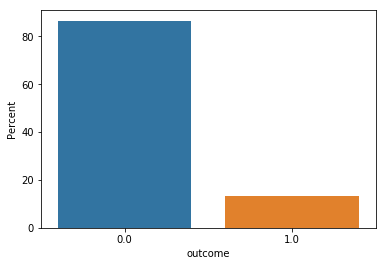

In [7]:
to_plot = train_bids.groupby('outcome')['bid_id'].count()
to_plot = to_plot.groupby(level=0).apply(lambda x: 100 * x / train_bids.shape[0]).reset_index()
print(to_plot)
ax = sns.barplot(x="outcome", y="bid_id", data=to_plot);
ax.set(ylabel="Percent");

In [8]:
to_plot = train_bids.groupby(['outcome', 'merchandise'])['bid_id'].count()

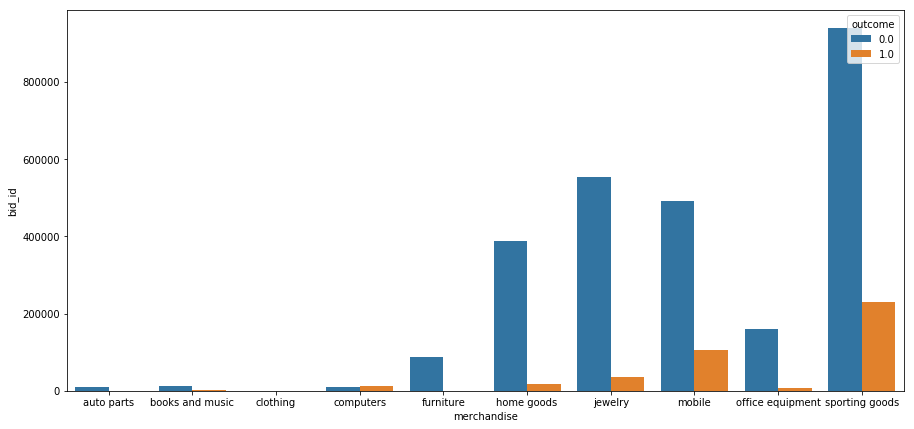

In [9]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(x='merchandise', y='bid_id', hue='outcome', data=to_plot.reset_index(), ax=ax);

Quantos paises por bidder?

In [39]:
unique_countries = train_bids.groupby(['bidder_id'])['country'].nunique()

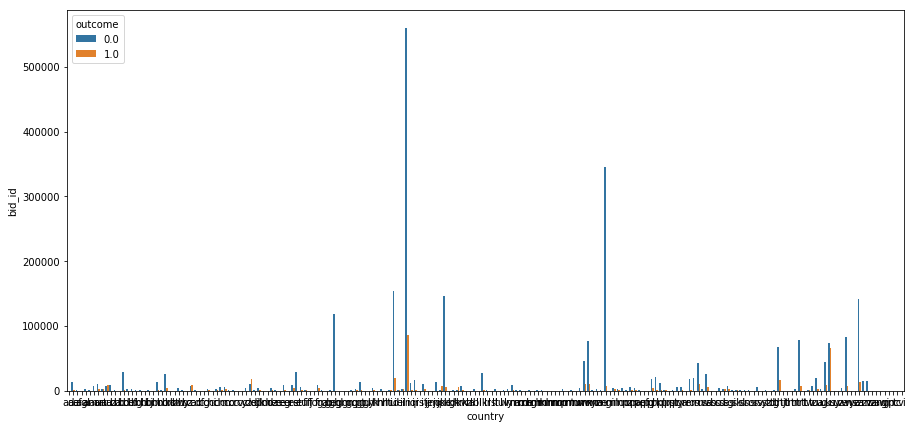

In [10]:
to_plot = train_bids.groupby(['outcome', 'country'])['bid_id'].count()
fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(x='country', y='bid_id', hue='outcome', data=to_plot.reset_index(), ax=ax);

In [10]:
X = train_bids.copy()
X.drop(['bid_id', 'outcome', 'time'], axis=1, inplace=True)
X = X[['bidder_id', 'payment_account', 'address']]

d = defaultdict(LabelEncoder)
X = X.apply(lambda x: d[x.name].fit_transform(x))
X.head()

,bidder_id,payment_account,address
1,796,1497,438
5,1803,153,522
9,1295,649,1288
10,1295,649,1288
13,985,1811,1979


In [13]:
y = np.ravel(train_bids.outcome)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
forest = ExtraTreesClassifier(
    n_estimators=250,
    criterion="entropy",
    min_samples_split=30,
    max_depth=10,
    random_state=42,
    n_jobs=4)
forest.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=10, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=30,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=4,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

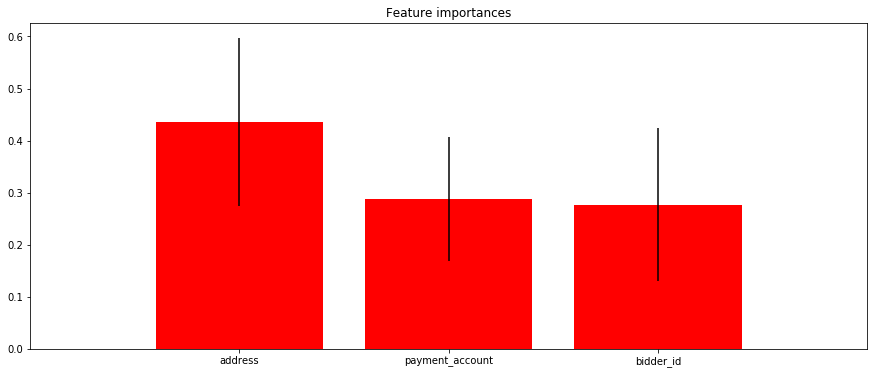

In [16]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_names = [X.columns[i] for i in indices]

plt.figure(figsize=(15,6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names)
plt.xlim([-1, X.shape[1]])
plt.show()

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 1.      0.    ]
 [ 0.1876  0.8124]]


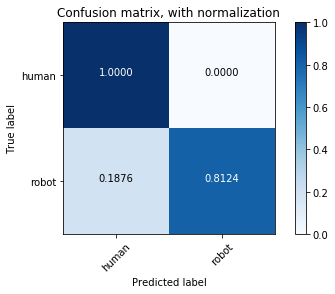

In [27]:
class_names = ['human', 'robot']
y_pred = forest.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=4)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix, with normalization')


In [28]:
precision_score(y_test, y_pred)

1.0

In [29]:
recall_score(y_test, y_pred)

0.81239809508434901

In [20]:
test = pd.read_csv('../input/test.csv')
test.head()

,bidder_id,payment_account,address
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,a3d2de7675556553a5f08e4c88d2c228htx90,5d9fa1b71f992e7c7a106ce4b07a0a754le7c
1,a921612b85a1494456e74c09393ccb65ylp4y,a3d2de7675556553a5f08e4c88d2c228rs17i,a3d2de7675556553a5f08e4c88d2c228klidn
2,6b601e72a4d264dab9ace9d7b229b47479v6i,925381cce086b8cc9594eee1c77edf665zjpl,a3d2de7675556553a5f08e4c88d2c228aght0
3,eaf0ed0afc9689779417274b4791726cn5udi,a3d2de7675556553a5f08e4c88d2c228nclv5,b5714de1fd69d4a0d2e39d59e53fe9e15vwat
4,cdecd8d02ed8c6037e38042c7745f688mx5sf,a3d2de7675556553a5f08e4c88d2c228dtdkd,c3b363a3c3b838d58c85acf0fc9964cb4pnfa


In [21]:
d = defaultdict(LabelEncoder)
test = test.apply(lambda x: d[x.name].fit_transform(x))

y_pred = forest.predict(test)

In [22]:
predic = pd.Series(y_pred)
predic.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
dtype: float64

In [23]:
test = test.apply(lambda x: d[x.name].inverse_transform(x))
test['prediction'] = predic
test.head()

,bidder_id,payment_account,address,prediction
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,a3d2de7675556553a5f08e4c88d2c228htx90,5d9fa1b71f992e7c7a106ce4b07a0a754le7c,0.0
1,a921612b85a1494456e74c09393ccb65ylp4y,a3d2de7675556553a5f08e4c88d2c228rs17i,a3d2de7675556553a5f08e4c88d2c228klidn,0.0
2,6b601e72a4d264dab9ace9d7b229b47479v6i,925381cce086b8cc9594eee1c77edf665zjpl,a3d2de7675556553a5f08e4c88d2c228aght0,0.0
3,eaf0ed0afc9689779417274b4791726cn5udi,a3d2de7675556553a5f08e4c88d2c228nclv5,b5714de1fd69d4a0d2e39d59e53fe9e15vwat,0.0
4,cdecd8d02ed8c6037e38042c7745f688mx5sf,a3d2de7675556553a5f08e4c88d2c228dtdkd,c3b363a3c3b838d58c85acf0fc9964cb4pnfa,0.0


In [24]:
test[['bidder_id', 'prediction']].to_csv('submission.csv', index=False)

In [25]:
test[test.bidder_id == 'eaf0ed0afc9689779417274b4791726cn5udi']

,bidder_id,payment_account,address,prediction
3,eaf0ed0afc9689779417274b4791726cn5udi,a3d2de7675556553a5f08e4c88d2c228nclv5,b5714de1fd69d4a0d2e39d59e53fe9e15vwat,0.0
